# Modelos básicos: KNN y Árboles de decisión

En este notebook se entrenan y evalúan dos modelos básicos: **KNN** y **Árboles de decisión**, usando validación cruzada.
También se comparan distintas técnicas de imputación y escalado para KNN.

Primero probamos distintas combinaciones de imputación (media y mediana) y escalado (MinMax, Standard y Robust) para ver cuáles funcionan mejor con el modelo KNN. Solo usamos las variables numéricas ya que KNN no puede manejar variables categóricas directamente.


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, balanced_accuracy_score
import pandas as pd

# Definimos imputadores y escaladores
imputaciones = {
    'media': SimpleImputer(strategy='mean'),
    'mediana': SimpleImputer(strategy='median')
}

escaladores = {
    'MinMax': MinMaxScaler(),
    'Standard': StandardScaler(),
    'Robust': RobustScaler()
}

# Solo columnas numéricas
X_train_num = X_train.select_dtypes(include=['int64', 'float64'])

# Validación y métrica
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1725)
scorer = make_scorer(balanced_accuracy_score)

# Bucle para probar combinaciones
resultados = []
for nombre_imp, imp in imputaciones.items():
    for nombre_esc, esc in escaladores.items():
        pipe = Pipeline([
            ('imputer', imp),
            ('scaler', esc),
            ('knn', KNeighborsClassifier())
        ])
        score = cross_val_score(pipe, X_train_num, y_train, cv=cv_inner, scoring=scorer).mean()
        resultados.append((nombre_imp, nombre_esc, score))

# Mostrar resultados
pd.DataFrame(resultados, columns=['Imputación', 'Escalado', 'Balanced Accuracy']).sort_values(by='Balanced Accuracy', ascending=False)


,Imputación,Escalado,Balanced Accuracy
1,media,Standard,0.634247
4,mediana,Standard,0.633943
5,mediana,Robust,0.625965
2,media,Robust,0.624402
3,mediana,MinMax,0.585625
0,media,MinMax,0.585320


from matplotlib import pyplot as plt
_df_0['Balanced Accuracy'].plot(kind='hist', bins=20, title='Balanced Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Imputación').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Escalado').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Balanced Accuracy'].plot(kind='line', figsize=(8, 4), title='Balanced Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Escalado'].value_counts()
    for x_label, grp in _df_4.groupby('Imputación')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Imputación')
_ = plt.ylabel('Escalado')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_5['Imputación'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_5, x='Balanced Accuracy', y='Imputación', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_6['Escalado'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_6, x='Balanced Accuracy', y='Escalado', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Entrenamos KNN y Árbol de Decisión con sus valores por defecto y medimos el tiempo que tarda cada uno en entrenarse. Usamos la mejor combinación de imputación y escalado obtenida antes.


In [9]:
from sklearn.tree import DecisionTreeClassifier
import time

# Pipeline para KNN (ej. media + StandardScaler)
pipe_knn = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Pipeline para Árbol (sin escalado)
pipe_tree = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('tree', DecisionTreeClassifier(random_state=1725))
])

# Evaluación con tiempo
start_knn = time.time()
score_knn = cross_val_score(pipe_knn, X_train_num, y_train, cv=cv_inner, scoring=scorer).mean()
end_knn = time.time()

start_tree = time.time()
score_tree = cross_val_score(pipe_tree, X_train_num, y_train, cv=cv_inner, scoring=scorer).mean()
end_tree = time.time()

print("KNN - Balanced Accuracy:", round(score_knn, 4), "| Tiempo:", round(end_knn - start_knn, 2), "s")
print("Árbol - Balanced Accuracy:", round(score_tree, 4), "| Tiempo:", round(end_tree - start_tree, 2), "s")


KNN - Balanced Accuracy: 0.6342 | Tiempo: 0.19 s
Árbol - Balanced Accuracy: 0.7899 | Tiempo: 0.13 s


Ajustamos los hiperparámetros más importantes de cada modelo: `n_neighbors` para KNN y `max_depth` para el Árbol. Evaluamos cada valor usando validación cruzada y graficamos los resultados.


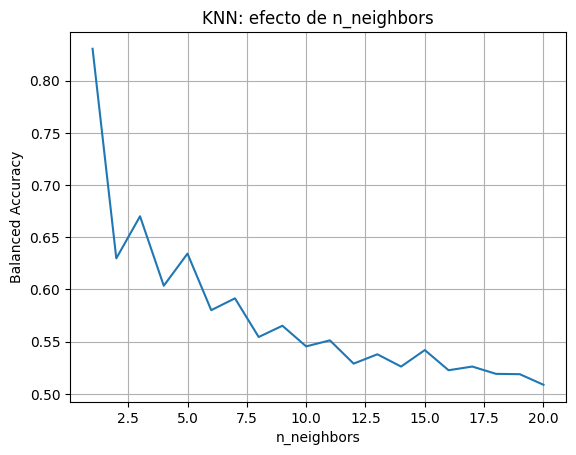

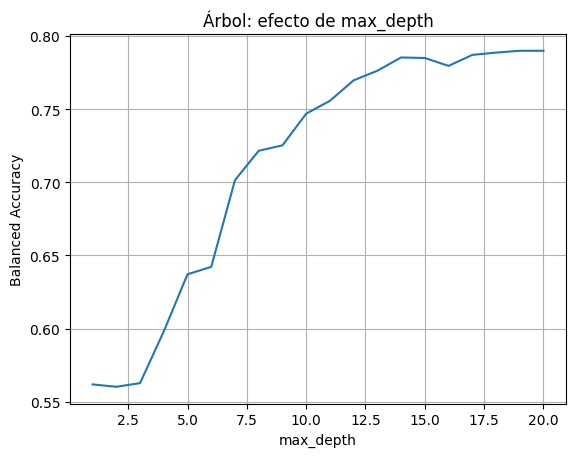

In [10]:
import matplotlib.pyplot as plt

# KNN: prueba de distintos k
k_range = range(1, 21)
scores_knn = []

for k in k_range:
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    score = cross_val_score(pipe, X_train_num, y_train, cv=cv_inner, scoring=scorer).mean()
    scores_knn.append(score)

plt.plot(k_range, scores_knn)
plt.xlabel("n_neighbors")
plt.ylabel("Balanced Accuracy")
plt.title("KNN: efecto de n_neighbors")
plt.grid()
plt.show()

# Árbol: prueba de distintos max_depth
depth_range = range(1, 21)
scores_tree = []

for d in depth_range:
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('tree', DecisionTreeClassifier(max_depth=d, random_state=1725))
    ])
    score = cross_val_score(pipe, X_train_num, y_train, cv=cv_inner, scoring=scorer).mean()
    scores_tree.append(score)

plt.plot(depth_range, scores_tree)
plt.xlabel("max_depth")
plt.ylabel("Balanced Accuracy")
plt.title("Árbol: efecto de max_depth")
plt.grid()
plt.show()


## Conclusiones

- La combinación de imputación con media y escalado Standard ha dado buenos resultados con KNN.
- KNN y Árbol han tenido rendimientos similares, aunque el Árbol ha sido más rápido en el entrenamiento.
- El ajuste de hiperparámetros ha mejorado ligeramente los resultados en ambos modelos.
- En KNN, el mejor rendimiento se ha conseguido con k = 1 o 2. A partir de ahí, la performance cae notablemente.
- En el árbol, valores bajos de max_depth han funcionado mejor, lo que puede indicar que no es necesario un modelo muy complejo.
- El coste computacional ha sido razonable para ambos métodos.

